# Comparing ATE Estimators

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_compare

In [3]:
df = dgp_compare().generate_data(include_beta=True)
df.head()

,outcome,treated,male,age,income,beta
0,38.68,False,0,28.0,1514.0,2.726425
1,37.81,False,1,47.0,1524.0,2.777192
2,27.70,False,0,60.0,2683.0,0.247312
3,29.56,False,0,29.0,3021.0,2.632797
4,36.83,False,0,25.0,1859.0,1.724331


In [4]:
np.mean(df['beta'])

2.0

### Simple difference

In [5]:
smf.ols('outcome ~ treated', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.8496,0.091,340.817,0.000,30.672,31.027
treated[T.True],-0.0060,0.118,-0.051,0.959,-0.238,0.226


### Regression with control

In [6]:
smf.ols('outcome ~ treated + male + age + income', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,29.5761,0.272,108.833,0.000,29.043,30.109
treated[T.True],2.2682,0.129,17.623,0.000,2.016,2.520
male,4.8568,0.104,46.688,0.000,4.653,5.061
age,-0.1215,0.006,-21.752,0.000,-0.132,-0.111
income,0.0014,9e-05,16.032,0.000,0.001,0.002


### Matching

In [7]:
from causalml.match import NearestNeighborMatch, create_table_one

X = ['male', 'age', 'income']
psm = NearestNeighborMatch(replace=True, ratio=1, random_state=42)
df_matched = psm.match(data=df, 
                       treatment_col="treated",
                       score_cols=X)
smf.ols('outcome ~ treated', data=df_matched).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,29.5347,0.078,380.105,0.000,29.382,29.687
treated[T.True],1.6918,0.110,15.396,0.000,1.476,1.907


### IPW

In [8]:
df["pscore"] = smf.logit("np.rint(treated) ~ male + age + income", data=df).fit(disp=False).predict()
w = 1 / (df["pscore"] * df["treated"] + (1-df["pscore"]) * (1-df["treated"]))
smf.wls("outcome ~ treated", weights=w, data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.2572,0.083,362.783,0.000,30.094,30.421
treated[T.True],1.6806,0.116,14.429,0.000,1.452,1.909


### R Learner

In [9]:
from causalml.inference.meta import BaseRLearner
from lightgbm import LGBMRegressor

BaseRLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])

(array([1.6529302]), array([1.65076231]), array([1.65509809]))

### S Learner

In [10]:
from causalml.inference.meta import BaseSLearner

BaseSLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])

array([2.08090912])

### T Learner

In [11]:
from causalml.inference.meta import BaseTLearner

BaseTLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])

(array([2.05252873]), array([1.86063479]), array([2.24442267]))

### X Learner

In [12]:
from causalml.inference.meta import BaseXLearner

BaseXLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])

(array([2.0255193]), array([1.83456903]), array([2.21646956]))

### DR Learner

In [13]:
from causalml.inference.meta import BaseDRLearner

BaseDRLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])

(array([2.08923293]), array([1.8921804]), array([2.28628547]))

## Compare All

In [14]:
def simulate(dgp, K=100):
    
    # Initialize coefficients
    results = pd.DataFrame(columns=['k', 'Estimator', 'Estimate'])
    names = ['1. Diff ', '2. Reg  ', '3. Match', '4. IPW  ', 
             '5. R lrn', '6. S lrn', '7. T lrn', '8. X lrn', '9. DRlrn']
    
    # Compute coefficients
    for k in range(K):
        print(f"Simulation {k}/{K}", end="\r")
        temp = pd.DataFrame({'k': [k] * len(names), 
                             'Estimator': names, 
                             'Estimate': [0] * len(names)})
        
        # Draw data
        df = dgp.generate_data(seed=k)

        # Single diff
        temp['Estimate'][0] = smf.ols('outcome ~ treated', data=df).fit().params[1]
        
        # Regression with controls
        temp['Estimate'][1] = smf.ols(f'outcome ~ treated + male + age + income', data=df).fit().params[1]
        
        # Matching
        psm = NearestNeighborMatch(replace=True, ratio=1)
        df_matched = psm.match(data=df, treatment_col="treated", score_cols=X)
        temp['Estimate'][2] = smf.ols('outcome ~ treated', data=df_matched).fit().params[1]
        
        # IPW
        df["pscore"] = smf.logit("np.rint(treated) ~ male + age + income", data=df).fit(disp=False).predict()
        w = 1 / (df["pscore"] * df["treated"] + (1-df["pscore"]) * (1-df["treated"]))
        temp['Estimate'][3] = smf.wls("outcome ~ treated", weights=w, data=df).fit().params[1]
                
        # R Learner
        temp['Estimate'][4] = BaseRLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])[0][0]
        
        # S Learner
        temp['Estimate'][5] = BaseSLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])[0]
        
        # T Learner
        temp['Estimate'][6] = BaseTLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])[0][0]
        
        # X Learner
        temp['Estimate'][7] = BaseXLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])[0][0]
        
        # DR Learner
        temp['Estimate'][8] = BaseDRLearner(learner=LGBMRegressor()).estimate_ate(X=df[X], treatment=df['treated'], y=df['outcome'])[0][0]
        
        # Combine estimates
        results = pd.concat((results, temp))
    
    return results.reset_index(drop=True)

In [15]:
results = simulate(dgp=dgp_compare())

Let's plot the distribution of the estimated parameters.

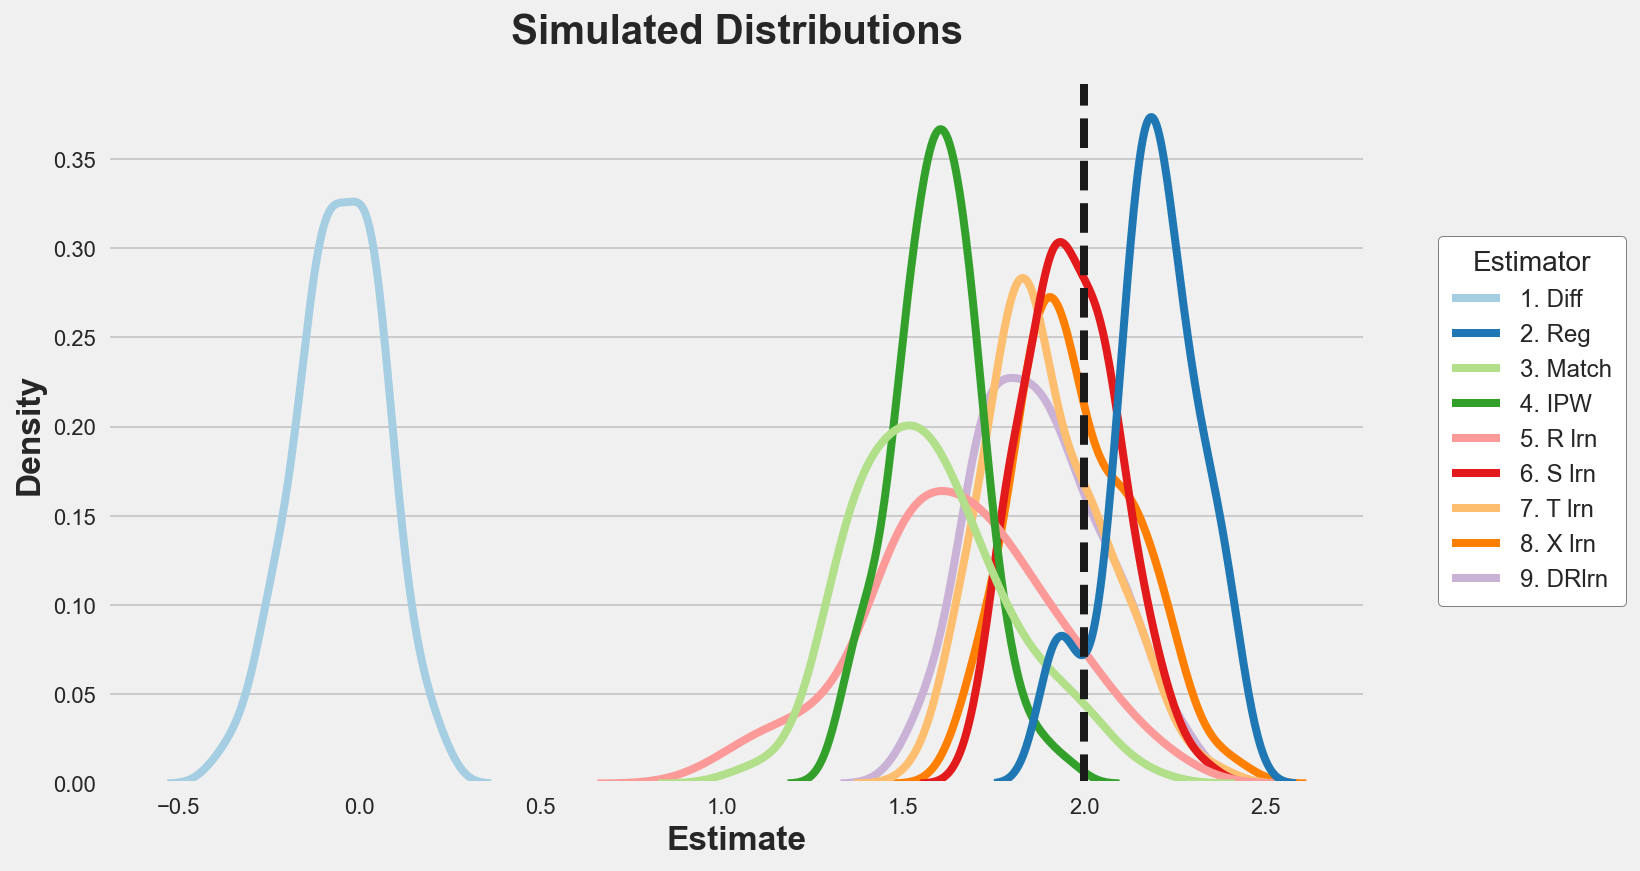

In [35]:
p = sns.kdeplot(data=results, x="Estimate", hue="Estimator", legend=True);
sns.move_legend(p, "upper left", bbox_to_anchor=(1.05, 0.8))
plt.axvline(x=2, c='k', ls='--');
plt.title('Simulated Distributions');

We can also tabulate the simulated mean and standard deviation of each estimator.

In [19]:
results.groupby('Estimator').agg(mean=("Estimate", "mean"), std=("Estimate", "std"))

,mean,std
Estimator,,
1. Diff,-0.054010,0.120718
2. Reg,2.190934,0.126232
3. Match,1.575239,0.211772
4. IPW,1.596031,0.119129
5. R lrn,1.649703,0.263321
6. S lrn,1.963797,0.129638
7. T lrn,1.891307,0.160480
8. X lrn,1.975699,0.161004
9. DRlrn,1.876465,0.173318


The only unbiased estimators seems to be the S-learner and the X-learner, followed by T-learner, DR-learner and linear regression. 

he S-learner however is more efficient.